In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import json
from numpy import linalg as LA
from sklearn.decomposition import PCA

import tensorflow as tf

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)

from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model
from tools_lnd import name_best_ckpt, gen_trials_from_model_dir, get_stim_cats
from task import generate_trials, rule_name
import tools

In [2]:
net = 'stepnet'#'highd_inputs'#'
### DAVID : this directs to a folder within the code from github
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model
import tools
from tools_lnd import make_axes, same_stim_trial, make_h_combined, name_best_ckpt, plot_N, make_Jac_u_dot_delu
from tools_lnd import make_h_and_Jac, gen_trials_from_model_dir, gen_X_from_model_dir_epoch, gen_X_from_model_dir


In [10]:
# task_list = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
#               'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
#               'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

# rule_set_names = ['DelayGo', 'ReactGo', 'MemoryGo', 'DelayAnti', 'ReactAnti', 'MemoryAnti',
#               'Decison1', 'Decison2', 'ContextDecison1', 'ContextDecison2', 'MultiDecison',
#               'DelayDecison1', 'DelayDecison2', 'ContextDelayDecison1', 'ContextDelayDecison2', 'MultiDelayDecison',
#               'DelayMatch2SampleGo', 'DelayMatch2SampleNogo', 'DelayMatch2CategoryGo', 'DelayMatch2CategoryNoGo']

# data_folder = os.path.join('data/rnn/multitask/',net,'final')
# rnn_type = 'LeakyRNN'
# activation = 'softplus'
# init = 'diag'
# seed = '0'
# n_rnn = str(256)
# l2w = -6
# l2h = -6
# l1w = 0
# l1h = 0
# lr = -7

# s = '_'
# rule_trains_str = s.join(task_list)
# net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str

# transfer_m = os.path.join(data_folder,rnn_type,activation,init,
#                           str(len(task_list))+'_tasks',str(n_rnn)+'_n_rnn',net_name,seed)

# m = os.path.join(p,transfer_m)

In [5]:
rule_set = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

rule_set_names = ['DelayGo', 'ReactGo', 'MemoryGo', 'DelayAnti', 'ReactAnti', 'MemoryAnti',
              'DelayDecison1', 'DelayDecison2', 'ContextDelayDecison1', 'ContextDelayDecison2', 'MultiDelayDecison',
              'DelayMatch2SampleGo', 'DelayMatch2SampleNogo', 'DelayMatch2CategoryGo', 'DelayMatch2CategoryNoGo']

In [40]:
m = '/Users/lauradriscoll/Documents/sherlock/multitask-nets/stepnet/data/all/LeakyRNN/softplus/randgauss/15_tasks/256_n_rnn/lr6.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2'


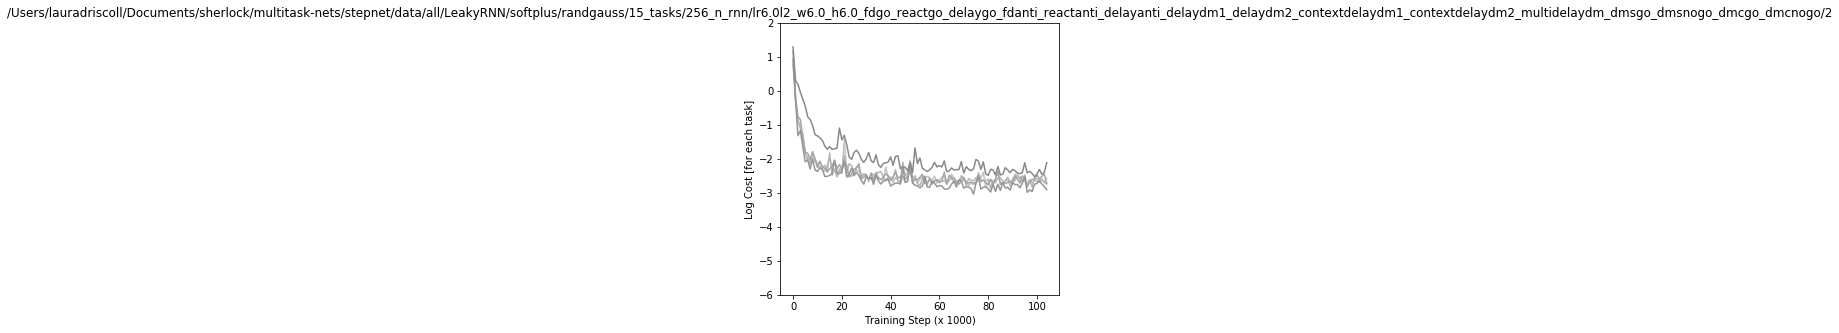

In [41]:
rule = rules_dict['all'][task_set[0]]

task_list = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

fig = plt.figure(figsize=(5, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(m, 'log.json')

with open(fname, 'r') as f:
    log_all = json.load(f)
for r in task_set:
    c = cmap(r/20)
    ax = fig.add_subplot(1,1,1)
    x = np.log(log_all['cost_'+rules_dict['all'][r]])
    plt.plot(x,'-',c = c)
    ax.set_xlabel('Training Step (x 1000)')
    ax.set_ylabel('Log Cost [for each task]')
    plt.ylim([-6,2])
    
plt.title(m)
plt.show()    

In [14]:
#These plots show some targets and outputs, again to show that the network looks sufficiently trained

rule = rules_dict['all'][13]
# ckpt_n = name_best_ckpt(model_dir_all,rule)
# ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))

model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='random', noise_on=True, batch_size =100, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) 

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


In [15]:
# Ok jumping into the meat of it- This code generates a list of hidden state activity 
# and input Jacobians for the different tasks.

def get_var_across_stim(model_dir_all,trial_master,task_num):
    trial = same_stim_trial(trial_master,task_num)
    X,x = gen_X_from_model_dir(model_dir_all,trial)
    var = np.var(x,axis=1)
    return var

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shap

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shap

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/2/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shap

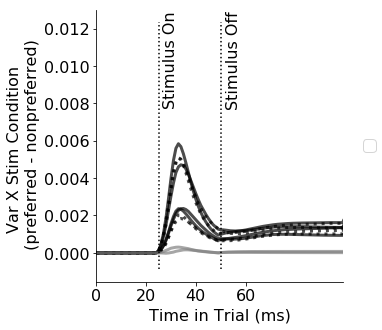

In [16]:
task_set = range(6,11)
# model_dir_all = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n_temp))
trial_master1 = gen_trials_from_model_dir(model_dir_all,'delaydm1',noise_on = False)
trial_master2 = gen_trials_from_model_dir(model_dir_all,'delaydm2',noise_on = False)
stim_start = trial_master1.epochs['stim1'][0]
stim_end = trial_master1.epochs['stim1'][1]
cmap=plt.get_cmap('coolwarm')
cl = [.1,.9,.3,.7,.5]
fig = plt.figure(figsize=(15, 5))
plt.rcParams.update({'font.size': 16})
ax = plt.subplot(1,3,2)
for model_n_temp in range(1,3):
    model_dir_all = os.path.join(m[:-1],str(model_n_temp))
#     ckpt_n = name_best_ckpt(model_dir_all,rule)
#     ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))
#     ckpt_n_dir = []
    for t in range(len(task_set)):
        task_num = task_set[t]
        var1 = get_var_across_stim(model_dir_all,trial_master1,task_num)
        var2 = get_var_across_stim(model_dir_all,trial_master2,task_num)
        var_diff = np.mean(var1,axis = 0) - np.mean(var2,axis = 0)
        
        if task_num==6:
            if model_n_temp==0:
                plt.plot(var_diff, label = 'Contextually Cued', color = 'k',linewidth = 3,alpha = .7)
            else:
                plt.plot(var_diff, color = 'k',linewidth = 3,alpha = .7)
                
        elif task_num==8:
            plt.plot(var_diff, color = 'k',linewidth = 3,alpha = .7)
            
        elif task_num==7 or task_num==9:
            plt.plot(-var_diff, ':k',linewidth = 3,alpha = .7)
            
        elif task_num==10:
            
            if model_n_temp==0:
                plt.plot(var_diff, label = 'Multimodal', color = 'gray',linewidth = 3,alpha = .7)
            else:
                plt.plot(var_diff, color = 'gray',linewidth = 3,alpha = .7)
            
        
# plt.plot([stim_start,stim_start],[-.055,.25],':k')

ymin, ymax = ax.get_ylim()
plt.plot([stim_end,stim_end],[ymin,ymax],':k')
plt.plot([stim_start,stim_start],[ymin,ymax],':k')

plt.text(stim_start+2,ymax,'Stimulus On',rotation = 90)
plt.text(stim_end+2,ymax,'Stimulus Off',rotation = 90)

plt.ylabel('Var X Stim Condition \n (preferred - nonpreferred)')
plt.xlabel('Time in Trial (ms)')
plt.xticks(range(0,80,20),range(0,80,20)*10)
plt.legend(loc='center left', bbox_to_anchor=[1.05,.5])
plt.xlim((0,99))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(figpath+'/vaxXstimCond.pdf')
plt.savefig(figpath+'/vaxXstimCond.png')
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shap

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shap

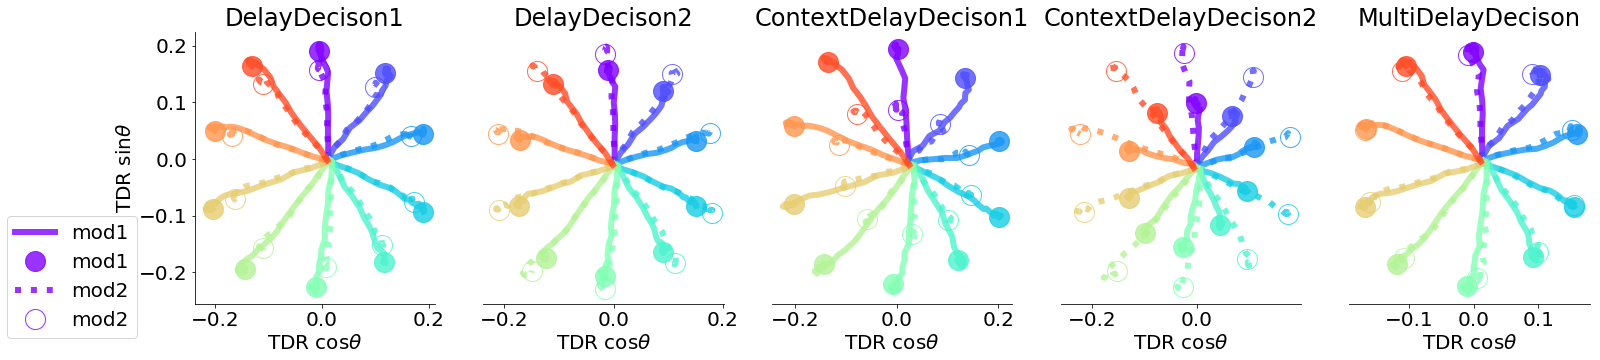

In [17]:
# model_dir_all = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n))
# ckpt_n = name_best_ckpt(model_dir_all,rule)
# ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))

task_set = range(6,11)
rule_master = rules_dict['all'][task_set[-1]]
epoch = 'stim1'
D = make_axes(m,rule_master,epoch,ind = -1,mod = 1)
trial_master1 = gen_trials_from_model_dir(m,'delaydm1',noise_on = False)
trial_master2 = gen_trials_from_model_dir(m,'delaydm2',noise_on = False)
trial_inds = range(trial_master1.epochs[epoch][0]-1,trial_master1.epochs[epoch][1])
ms = 20
lw = 6

cmap = plt.get_cmap('rainbow')
fig = plt.figure(figsize=(5*len(task_set), 5))
plt.rcParams.update({'font.size': 20})
for task_i in range(len(task_set)):
    
    task_num = task_set[task_i]
    trial1 = same_stim_trial(trial_master1,task_num)
    X1,x1 = gen_X_from_model_dir(m,trial1)
    
    trial2 = same_stim_trial(trial_master2,task_num)
    X2,x2 = gen_X_from_model_dir(m,trial2)

    ax = plt.subplot(1,len(task_set),task_i+1)
    for t in range(0,np.shape(x2)[1],int(np.shape(x2)[1]/10)):
        xi1 = np.dot(x1[:,t,:].T,D)
        xi2 = np.dot(x2[:,t,:].T,D)
        if t==0:
            plt.plot(xi1[trial_inds,0],xi1[trial_inds,1],c = cmap(t/np.shape(x2)[1]),label = 'mod1',alpha = .8,linewidth = lw)
            plt.plot(xi1[trial_inds[-1],0],xi1[trial_inds[-1],1],'o',c = cmap(t/np.shape(x2)[1]),
                     markersize = ms,alpha = .8,label = 'mod1')
            
            plt.plot(xi2[trial_inds,0],xi2[trial_inds,1],':',c = cmap(t/np.shape(x2)[1]),
                     linewidth = lw,label = 'mod2',alpha = .8)
            plt.plot(xi2[trial_inds[-1],0],xi2[trial_inds[-1],1],'o',c = cmap(t/np.shape(x2)[1]),
                     linewidth = lw,markerfacecolor = 'none',markersize = ms,alpha = .8,label = 'mod2')
        else:
            plt.plot(xi1[trial_inds,0],xi1[trial_inds,1],c = cmap(t/np.shape(x2)[1]),alpha = .8,linewidth = lw)
            plt.plot(xi1[trial_inds[-1],0],xi1[trial_inds[-1],1],'o',c = cmap(t/np.shape(x2)[1]),
                     linewidth = lw,markersize = ms,alpha = .8)
            
            plt.plot(xi2[trial_inds,0],xi2[trial_inds,1],':',c = cmap(t/np.shape(x2)[1]),linewidth = lw,alpha = .8)
            plt.plot(xi2[trial_inds[-1],0],xi2[trial_inds[-1],1],'o',c = cmap(t/np.shape(x2)[1]),
                     linewidth = lw,markerfacecolor = 'none',markersize = ms,alpha = .8)
#     plt.ylim((-.05,.09))    
#     plt.xlim((-.07,.07))    
    plt.title(rule_set_names[task_num])
    plt.xlabel(r'TDR cos$\theta$')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if task_i > 0:
        ax.spines['left'].set_visible(False)
        plt.yticks([])
plt.subplot(1,len(task_set),1)
plt.ylabel(r'TDR sin$\theta$')
plt.legend(loc='center right', bbox_to_anchor=[-.2,.1])
plt.savefig(figpath+'/visXstimCond.pdf')
plt.savefig(figpath+'/visXstimCond.png')
plt.show()

In [12]:
task_set

[11, 12, 13, 14, 15]

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


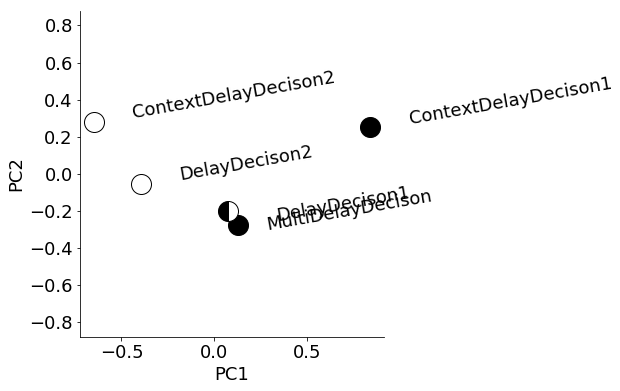

In [19]:
trial_set = (0,)#range(0,80,2)
task_set = range(6,11)
h_context_combined = make_h_combined(m,task_set,trial_set,epoch = 'stim1')
cl_fill = ['k','w','k','w','w']
cl_line = ['k','k','k','k','gray']
marker_fillalt_set = ['k','none','k','none','k']
ls = ['-',':','-',':','--']

X = h_context_combined
pca = PCA(n_components = 2)
h_pca_context = pca.fit_transform(X)

n_tasks = len(task_set)
fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(1,2,1)
plt.rcParams.update({'font.size': 18})

for r in range(n_tasks-1):
    plt.plot(h_pca_context[r,0],h_pca_context[r,1],'o',
             markerfacecolor=cl_fill[r],markeredgecolor='k',markersize = 20)
    plt.text(h_pca_context[r,0]+.2,h_pca_context[r,1],rule_set_names[task_set[r]],rotation=10,
                             ha="left", va="bottom")

r = n_tasks-1
plt.plot(h_pca_context[r,0],h_pca_context[r,1],'o',
         markerfacecolor=cl_fill[r],markeredgecolor='k',
         markerfacecoloralt=marker_fillalt_set[r],fillstyle='right',markersize = 20)
plt.text(h_pca_context[r,0]+.2,h_pca_context[r,1],rule_set_names[task_set[r]],rotation=10,
                         ha="left", va="center")
# plt.axis('off')
plt.xlabel('PC1')
plt.ylabel('PC2')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axis('equal')
plt.savefig(figpath+'/DelayDM_IC_PCs.pdf')
plt.savefig(figpath+'/DelayDM_IC_PCs.png')
plt.show()

In [12]:
task_set

[11, 12, 13, 14, 15]

In [15]:
task_set = range(6,11)
trial_master1 = gen_trials_from_model_dir(m,'delaydm1',noise_on = False)
trial_master2 = gen_trials_from_model_dir(m,'delaydm2',noise_on = False)
n_trials = np.shape(trial_master1.x)[1]
trial_set = range(0,n_trials,int(n_trials/50))

#This calculates input jacobian jacobians for trials where mod1>mod2 and when mod2>mod1
task_set = range(6,11)
time_set = (trial_master1.epochs['stim1'][0],)
J_np_u_dot_delu1 = make_Jac_u_dot_delu(m,'delaydm1',task_set,time_set,trial_set)
J_np_u_dot_delu2 = make_Jac_u_dot_delu(m,'delaydm2',task_set,time_set,trial_set)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variabl

0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.15811388

In [16]:
LA.norm(J_np_u_dot_delu2[t,:,0,:],axis = 1)

NameError: name 't' is not defined

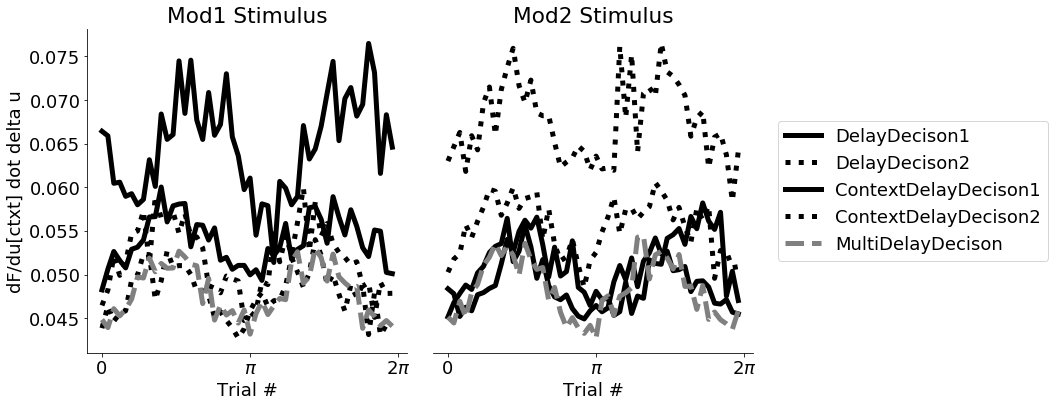

In [20]:
cmap=plt.get_cmap('coolwarm')
cl = [.1,.9,.2,.8,.5]
n_trials = np.shape(J_np_u_dot_delu1)[1]

fig = plt.figure(figsize=(15, 6),tight_layout=True,facecolor='white')
for t in range(len(task_set)):
    ax = plt.subplot(1,2,1)
    plt.plot(LA.norm(J_np_u_dot_delu1[t,:,0,:],axis = 1).T,ls[t],color = cl_line[t],
             label = rule_set_names[task_set[t]],linewidth = 5)
    plt.xticks(range(0,n_trials+1,int(n_trials/2)),['0',r'$\pi$',r'$2\pi$'])
    plt.xlabel('Trial #')
    plt.title('Mod1 Stimulus')
    plt.ylabel('dF/du[ctxt] dot delta u')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
#     plt.ylim((0.01,.02))

    ax = plt.subplot(1,2,2)
    plt.plot(LA.norm(J_np_u_dot_delu2[t,:,0,:],axis = 1).T,ls[t],label = rule_set_names[task_set[t]],
             color = cl_line[t],linewidth = 5)
    plt.xticks(range(0,n_trials+1,int(n_trials/2)),['0',r'$\pi$',r'$2\pi$'])
    plt.xlabel('Trial #')
    plt.title('Mod2 Stimulus')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
#     plt.ylim((0.01,.02))
    plt.yticks([])
    
plt.legend(loc='center left', bbox_to_anchor=[1.05,.5])
plt.savefig(figpath+'/J_np_u_dot_delu1.pdf')
plt.savefig(figpath+'/J_np_u_dot_delu1.png')
plt.show()

<function matplotlib.pyplot.show>

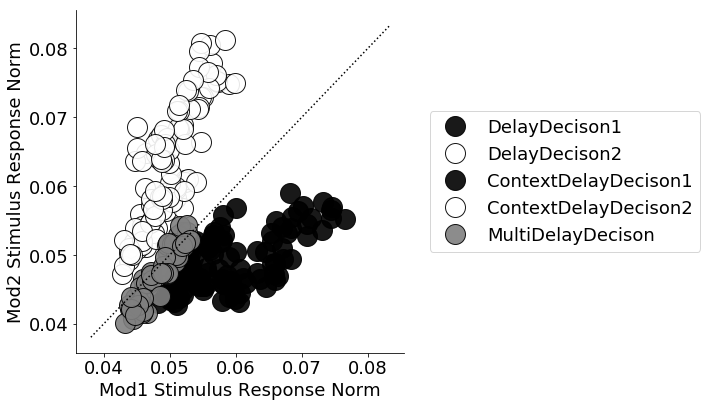

In [21]:
cl_fill = ['k','w','k','w','gray']
fig = plt.figure(figsize=(15, 6),tight_layout=True,facecolor='white')
ax = plt.subplot(1,2,1)
for t in range(len(task_set)):
    m1 = LA.norm(J_np_u_dot_delu1[t,:,0,:],axis = 1)
    m2 = LA.norm(J_np_u_dot_delu2[t,:,0,:],axis = 1)
    plt.plot(m1,m2,'o',label = rule_set_names[task_set[t]],alpha = .9,
             markerfacecolor=cl_fill[t],markeredgecolor='k',
             markersize = 20)
    
#markerfacecoloralt=marker_fillalt_set[t],fillstyle='right',
xleft, xright = ax.get_xlim()
yleft, yright = ax.get_ylim()
left = np.min((xleft,yleft))
right = np.max((xright,yright))
plt.plot([left,right],[left,right],':k')
plt.legend(loc='center left', bbox_to_anchor=[1.05,.5])
plt.ylabel('Mod2 Stimulus Response Norm')
plt.xlabel('Mod1 Stimulus Response Norm')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(figpath+'/Comparing_EffInput.pdf')
plt.savefig(figpath+'/Comparing_EffInput.png')
plt.show

In [35]:
def Jac_x(model_dir_all,ckpt_n_dir,rule,task_set,time_i,trial_set):

    model = Model(model_dir_all)
    with tf.Session() as sess:

        model.saver.restore(sess,ckpt_n_dir)
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        params = [sess.run(var) for var in var_list]
        # get hparams
        hparams = model.hp
        trial = generate_trials(rule, hparams, mode='test', noise_on=False, delay_fac =1)

        #get size of relevant variables to init mats
        n_inputs = np.shape(trial.x)[2]
        N = np.shape(params[0])[1]
        n_stim_dims = n_inputs - 20
        #change this depending on when in the trial you're looking [must be a transition btwn epochs]

        #init mats
        J_np_x = np.zeros((n_tasks,len(trial_set),N,N))

        for r in range(n_tasks):
            r_all_tasks_ind = task_set[r]

            trial.x[:,:,n_stim_dims:] = 0 #set all tasks to 0 #(n_time, n_trials, n_inputs)
            trial.x[:,:,n_stim_dims+r_all_tasks_ind] = 1 #except for this task

            feed_dict = tools.gen_feed_dict(model, trial, hparams)
            h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_trials, n_neuron)

            for trial_i in range(len(trial_set)): #depending on the analysis I was including one or many trials

                states = h_tf[time_i,trial_set[trial_i],:]
                states = states[np.newaxis,:]

                inputs = np.squeeze(trial.x[time_i,trial_set[trial_i],:]) #(n_time, n_condition, n_inputs)
                inputs = inputs[np.newaxis,:]
                
                inputs_tf = tf.constant(inputs, dtype=tf.float32)
                states_tf = tf.constant(states, dtype=tf.float32)
                output, new_states = model.cell(inputs_tf, states_tf)
                F = new_states

                J_tf_x = pfor.batch_jacobian(F, states_tf, use_pfor=False)
                J_np_x[r,trial_i,:,:] = sess.run(J_tf_x)
                
    return J_np_x

In [36]:
time_i = trial_master1.epochs['stim1'][0]-1
J_np_x1 = Jac_x(model_dir_all,ckpt_n_dir,'delaydm1',task_set,time_i,trial_set)
J_np_x2 = Jac_x(model_dir_all,ckpt_n_dir,'delaydm2',task_set,time_i,trial_set)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/1/ckpts/model.ckpt-344000
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.

0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.158113883008419
0.15811388

In [37]:
# h_context_combined = make_h_combined(model_dir_all,ckpt_n_dir,task_set,trial_set,epoch = 'stim1')
# h_context, h_stim_early, h_stim_late = make_h_combined(model_dir_all,ckpt_n_dir,task_set,(0,),n_steps_early = 0)
# h_ctxt = np.repeat(h_context_combined,n_trials,axis = 1)

del_x1 = np.squeeze(J_np_u_dot_delu1)#- h_ctxt
del_x2 = np.squeeze(J_np_u_dot_delu2)#- h_ctxt

n_tasks,n_trials,N,_ = np.shape(J_np_x1)
Jx_dot_eff_in1 = np.empty((n_tasks,n_trials,N))
Jx_dot_eff_in2 = np.empty((n_tasks,n_trials,N))

for task_i in range(n_tasks):
    for trial_i in range(n_trials):

        Jx_dot_eff_in1[task_i,trial_i,:] = np.dot(J_np_x1[task_i,trial_i,:,:],del_x1[task_i,trial_i,:].T)
        Jx_dot_eff_in2[task_i,trial_i,:] = np.dot(J_np_x2[task_i,trial_i,:,:],del_x2[task_i,trial_i,:].T)

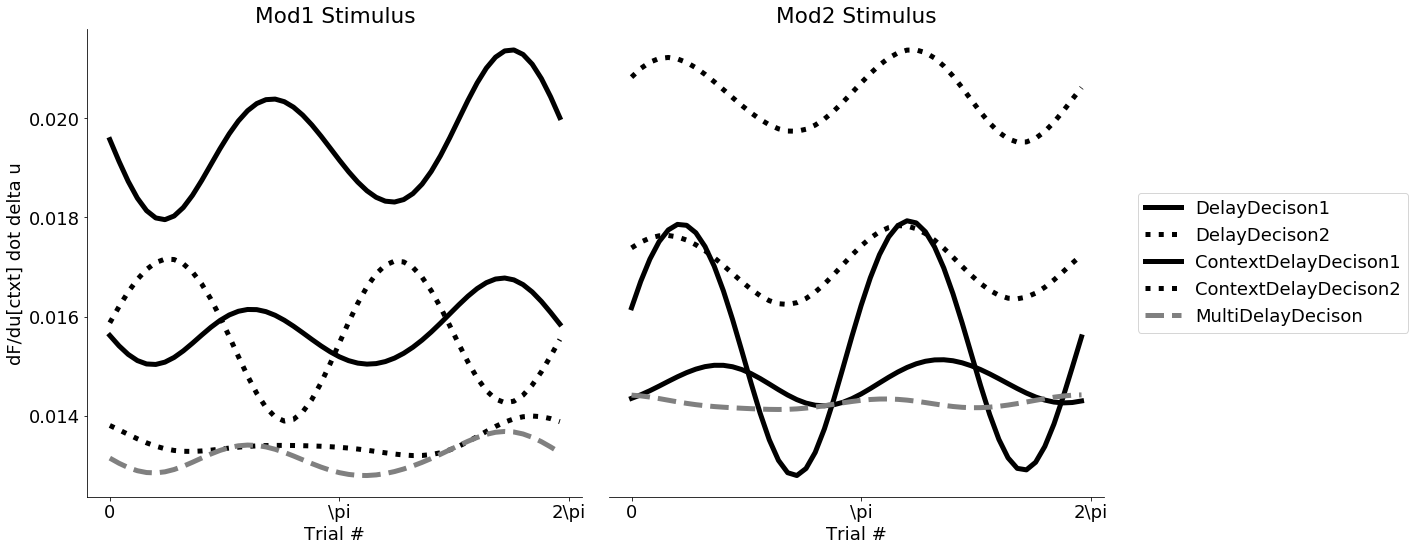

In [47]:
cmap=plt.get_cmap('coolwarm')
cl = [.1,.9,.2,.8,.5]
n_trials = np.shape(J_np_u_dot_delu1)[1]

fig = plt.figure(figsize=(20, 8),tight_layout=True,facecolor='white')
for t in range(len(task_set)):
    ax = plt.subplot(1,2,1)
    plt.plot(LA.norm(Jx_dot_eff_in1[t,:,:],axis = 1).T,ls[t],color = cl_line[t],
             label = rule_set_names[task_set[t]],linewidth = 5)
    plt.xticks(range(0,n_trials+1,int(n_trials/2)),[0,r'\pi',r'2\pi'])
    plt.xlabel('Trial #')
    plt.title('Mod1 Stimulus')
    plt.ylabel('dF/du[ctxt] dot delta u')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
#     plt.ylim((0.01,.02))

    ax = plt.subplot(1,2,2)
    plt.plot(LA.norm(Jx_dot_eff_in2[t,:,:],axis = 1).T,ls[t],color = cl_line[t],
             label = rule_set_names[task_set[t]],linewidth = 5)
    plt.xticks(range(0,n_trials+1,int(n_trials/2)),['0',r'\pi',r'2\pi'])
    plt.xlabel('Trial #')
    plt.title('Mod2 Stimulus')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
#     plt.ylim((0.01,.02))
    plt.yticks([])
    
plt.legend(loc='center left', bbox_to_anchor=[1.05,.5])
plt.savefig(fldr+'J_np_u_dot_delu1.pdf')
plt.savefig(fldr+'J_np_u_dot_delu1.png')
plt.show()

<function matplotlib.pyplot.show>

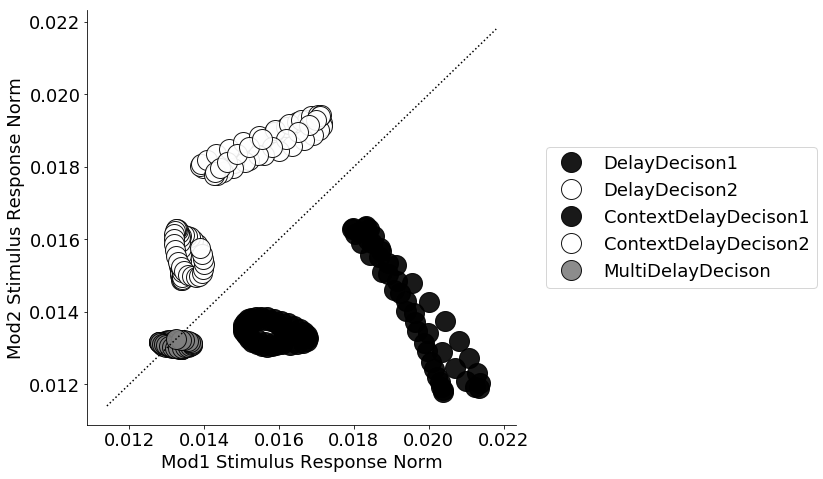

In [49]:
fig = plt.figure(figsize=(18, 7),tight_layout=True,facecolor='white')
ax = plt.subplot(1,2,1)
for t in range(len(task_set)):
    m1 = LA.norm(Jx_dot_eff_in1[t,:,:],axis = 1)
    m2 = LA.norm(Jx_dot_eff_in2[t,:,:],axis = 1)
    plt.plot(m1,m2,'o',label = rule_set_names[task_set[t]],alpha = .9,
             markerfacecolor=cl_fill[t],markeredgecolor='k',
             markersize = 20)
    

xleft, xright = ax.get_xlim()
yleft, yright = ax.get_ylim()
left = np.min((xleft,yleft))
right = np.max((xright,yright))
plt.plot([left,right],[left,right],':k')
plt.legend(loc='center left', bbox_to_anchor=[1.05,.5])
plt.ylabel('Mod2 Stimulus Response Norm')
plt.xlabel('Mod1 Stimulus Response Norm')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.title('Relaxation Dynamics')

plt.savefig(fldr+'Comparing_RelaxDynamics.pdf')
plt.savefig(fldr+'Comparing_RelaxDynamics.png')
plt.show

In [22]:
def eff_in_steps(model_dir_all,rule,n_steps,tasks,trial_set,h_context_ICs = []):

    if h_context_ICs is None:
        #make set of steps through contexts ICs
        h_context_combined = make_h_combined(model_dir_all,[8,9],trial_set)
        h_context_diff = h_context_combined[1,0,:] - h_context_combined[0,0,:]
        h_context_step = h_context_diff/n_steps

        h_context_ICs = h_context_combined[range(1),0,:]
        for s in range(n_steps):
            h_plus_step = h_context_ICs[s,:]+h_context_step
            h_context_ICs = np.concatenate((h_context_ICs,h_plus_step[np.newaxis,:]),axis = 0)

    #calc eff input across ICs and tasks
    n_tasks = len(tasks)
    eff_in = np.empty((n_tasks,n_steps+1,len(trial_set)))

    model = Model(model_dir_all)
    with tf.Session() as sess:
        model.saver.restore(sess,ckpt_n_dir)
        var_list = model.var_list
        params = [sess.run(var) for var in var_list]
        hparams = model.hp
        trial_master = generate_trials(rule, hparams, mode='test', noise_on=False, delay_fac =1)

        time_i = trial_master.epochs['stim1'][0]
        
        for t_ind in range(len(trial_set)):
            trial_i = trial_set[t_ind]

            for r in range(n_tasks):
                task_num = tasks[r]
                rule = rule = rules_dict['all'][task_num]
                trial = same_stim_trial(trial_master, task_num)

                for s in range(n_steps+1): #steps between two rules

                    states = h_context_ICs[s,:]
                    states = states[np.newaxis,:]

                    #calc Jac wrt inputs
                    inputs_context = np.squeeze(trial.x[time_i-1,trial_i,:]) #(n_time, n_condition, n_inputs)
                    inputs_context = inputs_context[np.newaxis,:]
                    inputs = np.squeeze(trial.x[time_i,trial_i,:]) #(n_time, n_condition, n_inputs)
                    inputs = inputs[np.newaxis,:]
                    delta_inputs = inputs - inputs_context

                    inputs_tf_context = tf.constant(inputs_context, dtype=tf.float32)
                    states_tf = tf.constant(states, dtype=tf.float32)
                    output, new_states = model.cell(inputs_tf_context, states_tf)
                    F = new_states

                    J_tf_u = pfor.batch_jacobian(F, inputs_tf_context, use_pfor=False)
                    J_np_u = sess.run(J_tf_u)
                    J_np_u_dot_delu = np.squeeze(np.dot(J_np_u,delta_inputs.T))
                    eff_in[r,s,t_ind] = LA.norm(J_np_u_dot_delu)
                    
                    J_tf_u = []
                    J_np_u = []
                    J_np_u_dot_delu = []
                
    return eff_in

In [23]:
n_steps = 6
tasks = range(11,16)
n_tasks = len(tasks)
task_A = 2
task_B = 3
cmap=plt.get_cmap('coolwarm')
colorlabel = [.1,.9,.5]

fig = plt.figure(figsize=(20, 10))

for model_n in range(1,2):
    model_dir_all = os.path.join(m[:-1],str(model_n))

    h_context_combinedA = make_h_combined(model_dir_all,[tasks[task_A],],50,'stim1')
    h_context_combinedB = make_h_combined(model_dir_all,[tasks[task_B],],50,'stim1')
    h_context_diff = h_context_combinedB - h_context_combinedA
    h_context_step = h_context_diff/n_steps

    h_context_ICs = h_context_combinedA[np.newaxis,:]
    for s in range(n_steps):
        h_plus_step = h_context_ICs[s,:]+h_context_step
        h_context_ICs = np.concatenate((h_context_ICs,h_plus_step[np.newaxis,:]),axis = 0)

    trial_master1 = gen_trials_from_model_dir(model_dir_all,'delaydm1',noise_on = False)
    trial_master2 = gen_trials_from_model_dir(model_dir_all,'delaydm2',noise_on = False)
    n_trials = np.shape(trial_master1.x)[1]
    trial_set = range(0,n_trials,int(n_trials/50))

    eff_in1 = eff_in_steps(model_dir_all,'delaydm1',n_steps,tasks,(0,),h_context_ICs = h_context_ICs)
    eff_in2 = eff_in_steps(model_dir_all,'delaydm2',n_steps,tasks,(0,),h_context_ICs = h_context_ICs)

    
    n_trials = np.shape(eff_in2)[2]

    plt.rcParams.update({'font.size': 16})
    for r in range(n_tasks):
        plt.subplot(2,3,1)
        plt.plot(np.mean(eff_in1[r,:,:],axis = 1),'o',
                 label = rule_set_names[tasks[r]],markersize = 10,alpha = .9,
             markerfacecolor=cl_fill[r],markeredgecolor='k')

        plt.subplot(2,3,2)
        if model_n==0:
            plt.plot(np.mean(eff_in2[r,:,:],axis = 1),'o',
                 label = rule_set_names[tasks[r]],markersize = 10,alpha = .9,
             markerfacecolor=cl_fill[r],markeredgecolor='k')
        else:
            plt.plot(np.mean(eff_in2[r,:,:],axis = 1),'o',markersize = 10,alpha = .9,
             markerfacecolor=cl_fill[r],markeredgecolor='k')

    ax1 = plt.subplot(2,3,1)
    xtick_set_labels = ['1',r'$1+\alpha$',r'$1+2\alpha$',r'$1+3\alpha$',r'$1+4\alpha$',r'$1+5\alpha$','2']
#     xtick_set_labels = [ '%.2f' % elem for elem in my_list ]
    plt.ylabel('Effective Input Norm')
    plt.xlabel('ICs [Steps Between Context 1 --> 2]')
    plt.title('Modality 1 Stimulus')
    plt.xticks(range(n_steps+1),xtick_set_labels,rotation = 45)

    ax2 = plt.subplot(2,3,2)
    plt.legend(loc='center left', bbox_to_anchor=[1.05,.5])
    plt.xlabel('ICs [Steps Between Context 1 --> 2]')
    plt.title('Modality 2 Stimulus')
    plt.xticks(range(n_steps+1),xtick_set_labels,rotation = 45)
    plt.yticks([])
    
    bottom1, top1 = ax1.get_ylim()
    bottom2, top2 = ax2.get_ylim()
    left = np.min((xleft,yleft))
    right = np.max((xright,yright))
    
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)

plt.savefig(fldr+'Step_Across_IC_A'+str(task_A)+'_B'+str(task_B)+'_All_Tasks.pdf')
plt.savefig(fldr+'Step_Across_IC_A'+str(task_A)+'_B'+str(task_B)+'_All_Tasks.png')

plt.show()

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/LeakyRNN/softplus/diag/15_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variabl

NameError: global name 'ckpt_n_dir' is not defined

<Figure size 1440x720 with 0 Axes>

In [107]:
n_steps = 6
tasks = range(11,16)
n_tasks = len(tasks)
task_A = 2
task_B = 3
cmap=plt.get_cmap('coolwarm')
colorlabel = [.1,.9,.5]
nc = 2
nr = 2

task_order = [2,3,0,1,4]

for model_n in range(1):
    
    fig = plt.figure(figsize=(11, 10))
    
    model_dir_all = os.path.join(p,'data/rnn/multitask/',dir_specific_all,str(model_n))
    ckpt_n = name_best_ckpt(model_dir_all,rule)
    ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))

    fldr = os.path.join(model_dir_all,'compare_effective_inputs_DelayDM/')
    if not os.path.exists(fldr):
        os.makedirs(fldr)

    h_context_combined, _, _ = make_h_combined(model_dir_all,ckpt_n_dir,tasks,0)
    h_context_diff = h_context_combined[task_B,0,:] - h_context_combined[task_A,0,:]
    h_context_step = h_context_diff/n_steps

    h_context_ICs = h_context_combined[(task_A,),0,:]
    for s in range(n_steps):
        h_plus_step = h_context_ICs[s,:]+h_context_step
        h_context_ICs = np.concatenate((h_context_ICs,h_plus_step[np.newaxis,:]),axis = 0)

    trial_master1 = gen_trials_from_model_dir(model_dir_all,'delaydm1',noise_on = False)
    trial_master2 = gen_trials_from_model_dir(model_dir_all,'delaydm2',noise_on = False)
    n_trials = np.shape(trial_master1.x)[1]
    trial_set = range(0,n_trials,int(n_trials/50))

    eff_in1 = eff_in_steps(model_dir_all,ckpt_n_dir,'delaydm1',n_steps,tasks,(0,),h_context_ICs = h_context_ICs)
    eff_in2 = eff_in_steps(model_dir_all,ckpt_n_dir,'delaydm2',n_steps,tasks,(0,),h_context_ICs = h_context_ICs)

    n_trials = np.shape(eff_in2)[2]

    plt.rcParams.update({'font.size': 16})
    for r in task_order:
        
        ax1 = plt.subplot(nr,nc,1)
        plt.plot(np.mean(eff_in1[r,:,:],axis = 1),'o',
                 label = rule_set_names[tasks[r]],markersize = 10,alpha = .9,
             markerfacecolor=cl_fill[r],markeredgecolor='k')
        
        xtick_set_labels = ['1',r'$1+\alpha$',r'$1+2\alpha$',r'$1+3\alpha$',r'$1+4\alpha$',r'$1+5\alpha$','2']
        plt.ylabel('Effective Input Norm')
        plt.xlabel('ICs [Steps Between Context 1 --> 2]')
        plt.title('Modality 1 Stimulus')
        plt.ylim((.05,.18))
        plt.xticks(range(n_steps+1),xtick_set_labels,rotation = 45)
        
        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)

        ax2 = plt.subplot(nc,nc,2)
        plt.plot(np.mean(eff_in2[r,:,:],axis = 1),'o',markersize = 10,alpha = .9,
             markerfacecolor=cl_fill[r],markeredgecolor='k')

        plt.xlabel('ICs [Steps Between Context 1 --> 2]')
        plt.title('Modality 2 Stimulus')
        plt.ylim((.05,.18))
        plt.xticks(range(n_steps+1),xtick_set_labels,rotation = 45)
        plt.yticks([])

        ax2.spines['right'].set_visible(False)
        ax2.spines['top'].set_visible(False)

        plt.savefig(fldr+'Step_Across_IC_A'+str(task_A)+'_B'+str(task_B)+'_'+rule_set_names[tasks[r]]+'.pdf')
        plt.savefig(fldr+'Step_Across_IC_A'+str(task_A)+'_B'+str(task_B)+'_'+rule_set_names[tasks[r]]+'.png')

plt.show()

OSError: [Errno 2] No such file or directory: '/Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/'

<Figure size 792x720 with 0 Axes>

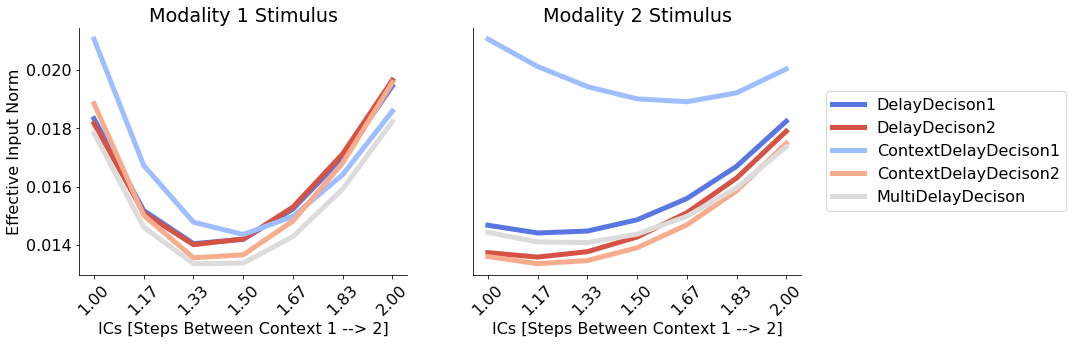

In [108]:
cmap=plt.get_cmap('coolwarm')
colorlabel = [.1,.9,.5]
n_trials = np.shape(eff_in2)[2]
n_tasks = len(tasks)

fig = plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 16})
for r in range(n_tasks):
    plt.subplot(2,3,1)
    plt.plot(np.mean(eff_in1[r,:,:],axis = 1),'-',label = rule_set_names[tasks[r]],linewidth = 5,color = cmap(cl[r]))

    plt.subplot(2,3,2)
    plt.plot(np.mean(eff_in2[r,:,:],axis = 1),'-',label = rule_set_names[tasks[r]],linewidth = 5,color = cmap(cl[r]))

ax1 = plt.subplot(2,3,1)
my_list = np.arange(1,2.1,1/(n_steps))
xtick_set_labels = [ '%.2f' % elem for elem in my_list ]
plt.ylabel('Effective Input Norm')
plt.xlabel('ICs [Steps Between Context 1 --> 2]')
plt.title('Modality 1 Stimulus')
# plt.ylim((.035,.045))
plt.xticks(range(n_steps+1),xtick_set_labels,rotation = 45)

ax2 = plt.subplot(2,3,2)
my_list = np.arange(1,2.1,1/(n_steps))
xtick_set_labels = [ '%.2f' % elem for elem in my_list ]
plt.legend(loc='center left', bbox_to_anchor=[1.05,.5])
plt.xlabel('ICs [Steps Between Context 1 --> 2]')
plt.title('Modality 2 Stimulus')
# plt.ylim((.035,.045))
plt.xticks(range(n_steps+1),xtick_set_labels,rotation = 45)
plt.yticks([])

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.savefig(fldr+'Step_Across_IC_A'+str(task_A)+'_B'+str(task_B)+'.pdf')
plt.savefig(fldr+'Step_Across_IC_A'+str(task_A)+'_B'+str(task_B)+'.png')

plt.show()

In [109]:
def make_Jac_at_spot(model_dir_all,rule,h_set):
    
    model = Model(model_dir_all)
    with tf.Session() as sess:
        model.saver.restore(sess,ckpt_n_dir)
        model._sigma=0
        var_list = model.var_list
        hparams = model.hp
        trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size =1, delay_fac =1)
        
        J_np_u = np.empty((np.shape(h_set)[0],hparams['n_rnn'],hparams['n_input']))
        for h_ind in range(np.shape(h_set)[0]):
            states = h_set[h_ind,:]
            states = states[np.newaxis,:]

            inputs = trial.x[0,0,:]
            inputs = inputs[np.newaxis,:]

            inputs_tf = tf.constant(inputs, dtype=tf.float32)
            states_tf = tf.constant(states, dtype=tf.float32)
            output, new_states = model.cell(inputs_tf, states_tf)
            F = new_states

            J_tf_u = pfor.batch_jacobian(F, inputs_tf, use_pfor=False)
            J_np_u[h_ind,:,:] = sess.run(J_tf_u)
    
    return J_np_u

In [110]:
trial_set = (0,)
task_set = range(11,16)
n_tasks = len(task_set)
h_context_combined = make_h_combined(model_dir_all,ckpt_n_dir,task_set,trial_set)
X = h_context_combined[:,0,:]
pca = PCA(n_components = 2)
h_pca_context = pca.fit_transform(X)

TypeError: make_h_combined() takes exactly 5 arguments (4 given)

In [94]:
task_order = [0,2,1,3,4]
n_tasks = len(task_order)
dist_mat = np.empty((n_tasks,n_tasks))
label_set = []

for dim1 in range(n_tasks):#range(n_tasks):
    label_set = np.concatenate((label_set,(rule_set_names[task_set[task_order[dim1]]],)))
    for dim2 in range(n_tasks):
        dist_mat[dim1,dim2] = LA.norm(X[task_order[dim1],:]-X[task_order[dim2],:])

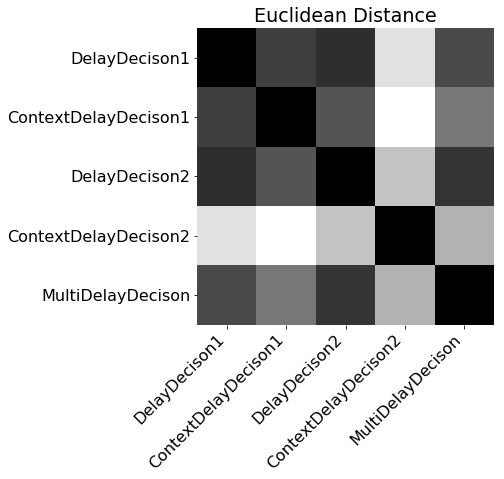

In [95]:
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(2,2,2)
plt.imshow(dist_mat,cmap='gray')
plt.xticks(range(n_tasks),label_set,rotation = 45,ha="right")
plt.yticks(range(n_tasks),label_set)

plt.title('Euclidean Distance')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.savefig(fldr+'Euc_Dist_Mat.pdf')
plt.savefig(fldr+'Euc_Dist_Mat.png')
plt.show()

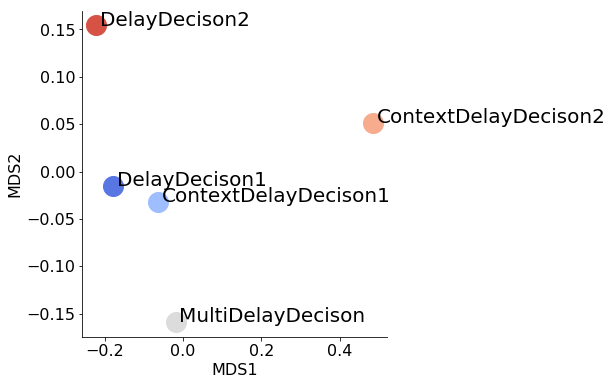

In [96]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2,dissimilarity='precomputed')
X_MDS = embedding.fit_transform(dist_mat)

n_tasks = len(task_set)
fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(1,2,1)
plt.rcParams.update({'font.size': 20})
cmap=plt.get_cmap('coolwarm')
cl = [.1,.9,.3,.7,.5]

for r in range(n_tasks):
    plt.plot(X_MDS[r,0],X_MDS[r,1],'o',color = cmap(cl[r]),markersize = 20)
    plt.text(X_MDS[r,0]+.01,X_MDS[r,1],rule_set_names[task_set[r]])

# plt.axis('off')
plt.xlabel('MDS1')
plt.ylabel('MDS2')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(fldr+'DelayDM_IC_MDS.pdf')
plt.savefig(fldr+'DelayDM_IC_MDS.png')
plt.show()

In [97]:
trial = gen_trials_from_model_dir(model_dir_all,'contextdelaydm1',noise_on = False)

n_steps = 6
trial1_set = range(12,3200,16)
trial2_set = range(3,3200,16)
n_trials = len(trial1_set)

task_set = range(11,16)
n_tasks = len(task_set)

eff_in1 = np.empty((n_tasks,n_steps+1,n_trials))
eff_in2 = np.empty((n_tasks,n_steps+1,n_trials))

starting_loc = h_context_combined[4,0,:]

for task_i in range(n_tasks):
    r = task_set[task_i]
    rule = rules_dict['all'][r]
    
    h_context_diff = h_context_combined[task_i,0,:] - starting_loc
    h_context_step = h_context_diff/n_steps
    u = trial.x[0,0,:]

    h_context_ICs = starting_loc[np.newaxis,:]
    for s in range(n_steps):
        h_plus_step = h_context_ICs[s,:]+h_context_step
        h = h_plus_step
        h_context_ICs = np.concatenate((h_context_ICs,h[np.newaxis,:]),axis = 0)

    J_np_u = make_Jac_at_spot(model_dir_all,rule,h_context_ICs)

    for t in range(n_trials):
        time_i = trial.epochs['stim1'][0]

        trial_1 = trial1_set[t]
        del_u1 = trial.x[time_i,trial_1,:]-trial.x[time_i-1,trial_1,:]

        trial_2 = trial2_set[t]
        del_u2 = trial.x[time_i,trial_2,:]-trial.x[time_i-1,trial_2,:]
        
        for si in range(n_steps+1):
            eff_in1[task_i,si,t] = LA.norm(np.dot(J_np_u[si,:,:],del_u1.T))
            eff_in2[task_i,si,t] = LA.norm(np.dot(J_np_u[si,:,:],del_u2.T))

ValueError: No hp found for model_dir /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0

In [98]:
1/maxval

NameError: name 'maxval' is not defined

In [99]:
eff_in = np.mean(eff_in1 - eff_in2,axis = 2)
# minval = np.min(eff_in.flatten())
maxval = np.max(np.abs(eff_in.flatten()))
minval = np.min(eff_in.flatten())
eff_in_norm = (eff_in)*200 + .5

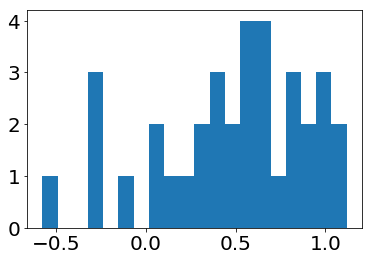

In [100]:
plt.hist(eff_in_norm.flatten(),20)
plt.show()

In [101]:
fig = plt.figure(figsize=(10, 10))
cmap=plt.get_cmap('coolwarm')

for r in range(n_tasks):
    
    h_context_diff = h_context_combined[r,0,:] - starting_loc
    h_context_step = h_context_diff/n_steps

    h_context_ICs = starting_loc[np.newaxis,:]
    for s in range(n_steps):
        h_plus_step = h_context_ICs[s,:]+h_context_step
        h = h_plus_step
        h_context_ICs = np.concatenate((h_context_ICs,h[np.newaxis,:]),axis = 0)
        
        loc = pca.transform(h_plus_step[np.newaxis,:])
        plt.plot(loc[0,0],loc[0,1],'o',color = cmap(1-eff_in_norm[r,s]),markersize = abs(eff_in_norm[r,s])*5)
    
    plt.plot(h_pca_context[r,0],h_pca_context[r,1],'ok',markersize = 5)
    plt.text(h_pca_context[r,0]+.005,h_pca_context[r,1],rule_set_names[task_set[r]],fontsize = 20)
        
    
plt.xlabel('PC1')
plt.ylabel('PC2')

IndexError: too many indices for array

<Figure size 720x720 with 0 Axes>

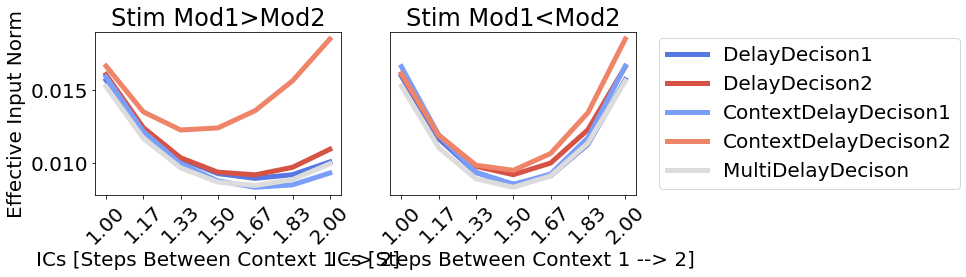

In [102]:
cmap=plt.get_cmap('coolwarm')
colorlabel = [.1,.9,.2,.8,.5]
n_trials = np.shape(eff_in2)[2]

fig = plt.figure(figsize=(15, 3))
for r in range(n_tasks):
    plt.subplot(1,3,1)
    plt.plot(np.mean(eff_in1[r,:,:],axis = 1),'-',label = rule_set_names[task_set[r]],linewidth = 5,color = cmap(colorlabel[r]))

    plt.subplot(1,3,2)
    plt.plot(np.mean(eff_in2[r,:,:],axis = 1),'-',label = rule_set_names[task_set[r]],linewidth = 5,color = cmap(colorlabel[r]))

plt.subplot(1,3,1)
my_list = np.arange(1,2.1,1/(n_steps))
xtick_set_labels = [ '%.2f' % elem for elem in my_list ]
plt.ylabel('Effective Input Norm')
plt.xlabel('ICs [Steps Between Context 1 --> 2]')
plt.title('Stim Mod1>Mod2')
# plt.ylim((.035,.045))
plt.xticks(range(n_steps+1),xtick_set_labels,rotation = 45)

plt.subplot(1,3,2)
my_list = np.arange(1,2.1,1/(n_steps))
xtick_set_labels = [ '%.2f' % elem for elem in my_list ]
plt.legend(loc='center left', bbox_to_anchor=[1.05,.5])
plt.xlabel('ICs [Steps Between Context 1 --> 2]')
plt.title('Stim Mod1<Mod2')
# plt.ylim((.035,.045))
plt.xticks(range(n_steps+1),xtick_set_labels,rotation = 45)
plt.yticks([])
plt.show()

In [103]:
r_set = range(len(task_set))
cmap=plt.get_cmap('tab20')
a = .6
mSize = 30
n_stim = int(np.shape(J_np_u_dot_delu)[1]/2)

fig = plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 14})
plt.subplot(1,2,1)
for stim1 in range(n_stim):
    for r in r_set:
        c = cmap(r/20)
        if stim1 == 0:
            plt.subplot(1,2,1)
            plt.plot(stim1,LA.norm(J_np_u_dot_delu[r,stim1,:]),'*',markersize = mSize,alpha = a, c = c,label = rules_dict['all'][task_set[r]])
            plt.subplot(1,2,2)
            plt.plot(stim1,LA.norm(J_np_u_dot_delu[r,stim1+n_stim,:]),'*',markersize = mSize,alpha = a, c = c,label = rules_dict['all'][task_set[r]])
        else:
            plt.subplot(1,2,1)
            plt.plot(stim1,LA.norm(J_np_u_dot_delu[r,stim1,:]),'*',markersize = mSize,alpha = a, c = c)
            plt.subplot(1,2,2)
            plt.plot(stim1,LA.norm(J_np_u_dot_delu[r,stim1+n_stim,:]),'*',markersize = mSize,alpha = a, c = c)

plt.subplot(1,2,1)
plt.xlabel('stim conditions mod1')
plt.ylabel('norm(dfdx dot delta_u)')
plt.ylim((0,.5))

plt.subplot(1,2,2)
plt.xlabel('stim conditions mod2')
plt.ylim((0,.5))

plt.legend()
plt.show()

NameError: name 'J_np_u_dot_delu' is not defined

In [104]:
model = Model(model_dir_all)
with tf.Session() as sess:

    ckpt_n = name_best_ckpt(model_dir_all,rule)
    ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))
    model.saver.restore(sess,ckpt_n_dir)
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp
    trial_delaygo = generate_trials('delaygo', hparams, mode='test', noise_on=False, delay_fac =1)
    trial_contextdm1 = generate_trials('contextdm1', hparams, mode='test', noise_on=False, delay_fac =1)

ValueError: No hp found for model_dir /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0

In [105]:
np.shape(trial_delaygo.x)

NameError: name 'trial_delaygo' is not defined

In [ ]:
r_set = range(2)
cmap=plt.get_cmap('tab20')

fig = plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 14})
plt.subplot(1,2,1)
for stim1 in range(hparams['n_eachring']):
    for r in r_set:
        c = cmap(r/20)
        if stim1 == 0:
            plt.subplot(1,2,1)
            plt.plot(stim1,LA.norm(J_np_u_dot_delu[r,stim1,:,:]),'*',markersize = mSize,alpha = a, c = c,label = rule_set[task_set[r]])
            plt.subplot(1,2,2)
            plt.plot(stim1,LA.norm(J_np_u_dot_delu[r,stim1+hparams['n_eachring'],:,:]),'*',markersize = mSize,alpha = a, c = c,label = rule_set[task_set[r]])
        else:
            plt.subplot(1,2,1)
            plt.plot(stim1,LA.norm(J_np_u_dot_delu[r,stim1,:,:]),'*',markersize = mSize,alpha = a, c = c)
            plt.subplot(1,2,2)
            plt.plot(stim1,LA.norm(J_np_u_dot_delu[r,stim1+hparams['n_eachring'],:,:]),'*',markersize = mSize,alpha = a, c = c)

plt.subplot(1,2,1)
plt.xlabel('8 stim conditions mod1')
plt.ylabel('norm(dfdx dot delta_u)')
plt.ylim((-.1,.5))

plt.subplot(1,2,2)
plt.xlabel('8 stim conditions mod2')
plt.ylim((-.1,.5))

plt.legend()
plt.show()

In [ ]:
n_eachring = 8
pref = np.arange(0,2*np.pi,2*np.pi/n_eachring)
x_loc = 2*np.pi/4
dist = (x_loc - pref)/(2*np.pi/128)
activation = 0.8*np.exp(-dist**2/2)

In [ ]:
plt.plot(activation,'ok')
plt.show()

In [ ]:
model_dir_all = os.path.join(p,'data/networks_for_david/',dir_specific,str(model_n))
J_np_u_dot_delu, h_context_combined, h_stim_late_combined, h_stim_early_combined = make_h_and_Jac(model_dir_all)

# Distances across different tasks
dist = DistanceMetric.get_metric('euclidean')
X_euc_context = dist.pairwise(np.squeeze(h_context_combined))
X_euc_stim_early = dist.pairwise(np.squeeze(h_stim_early_combined-h_context_combined))
X_euc_stim_late = dist.pairwise(np.squeeze(h_stim_late_combined-h_context_combined))
X_euc_stim_Jac = dist.pairwise(np.reshape(np.squeeze(J_np_u_dot_delu),(n_tasks,-1)))

# MDS for each metric
X_context = do_MDS(h_context_combined)
X_del_stim_early = do_MDS(h_stim_early_combined-h_context_combined)
X_del_stim_late = do_MDS(h_stim_late_combined-h_context_combined)
X_stim_Jac = do_MDS(np.reshape(np.squeeze(J_np_u_dot_delu),(n_tasks,-1)))

fig = plt.figure(figsize=(40, 20),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 30})

ax1 = plt.subplot(2,4,1)
plot_MDS_tasks(X_context)
plt.title('Context Hidden State')

ax2 = plt.subplot(2,4,2)
plot_MDS_tasks(X_del_stim_early)
plt.title('Stimulus Hidden State [Early]')

ax2 = plt.subplot(2,4,3)
plot_MDS_tasks(X_del_stim_late)
plt.title('Stimulus Hidden State [Late]')

ax2 = plt.subplot(2,4,4)
plot_MDS_tasks(X_stim_Jac)
plt.title('Stimulus Jacobian')

ax3 = plt.subplot(2,4,5)
plt.plot(X_euc_context[:],X_euc_stim_early[:],'.k')
plt.xlabel('Context Hidden State')
plt.ylabel('Stimulus Hidden State [Early]')

ax3 = plt.subplot(2,4,6)
plt.plot(X_euc_context[:],X_euc_stim_late[:],'.k')
plt.xlabel('Context Hidden State')
plt.ylabel('Stimulus Hidden State [Late]')

ax3 = plt.subplot(2,4,7)
plt.plot(X_euc_stim_early[:],X_euc_stim_late[:],'.k')
plt.xlabel('Stimulus Hidden State [Early]')
plt.ylabel('Stimulus Hidden State [Late]')

ax3 = plt.subplot(2,4,8)
plt.plot(X_euc_context[:],X_euc_stim_Jac[:],'.k')
plt.xlabel('Context Hidden State')
plt.ylabel('Stimulus Jacobian')

plt.show()

In [ ]:
X_euc_context_all = {}
X_euc_stim_early_all = {}
X_euc_stim_late_all = {}
X_euc_stim_Jac_all = {}


for d in range(len(dir_set)):
    dir_specific = dir_set[d]
    model_dir_all = os.path.join(p,'data/networks_for_david/',dir_specific,str(model_n))
    J_np_u_dot_delu, h_context_combined, h_stim_late_combined, h_stim_early_combined = make_h_and_Jac(model_dir_all)

    # Distances across different tasks
    dist = DistanceMetric.get_metric('euclidean')
    X_euc_context = dist.pairwise(np.squeeze(h_context_combined))
    X_euc_stim_early = dist.pairwise(np.squeeze(h_stim_early_combined-h_context_combined))
    X_euc_stim_late = dist.pairwise(np.squeeze(h_stim_late_combined-h_context_combined))
    X_euc_stim_Jac = dist.pairwise(np.reshape(np.squeeze(J_np_u_dot_delu),(n_tasks,-1)))

    # MDS for each metric
    X_context = do_MDS(h_context_combined)
    X_del_stim_early = do_MDS(h_stim_early_combined-h_context_combined)
    X_del_stim_late = do_MDS(h_stim_late_combined-h_context_combined)
    X_stim_Jac = do_MDS(np.reshape(np.squeeze(J_np_u_dot_delu),(n_tasks,-1)))

    X_euc_context_all[dir_specific] = X_euc_context
    X_euc_stim_early_all[dir_specific] = X_euc_stim_early
    X_euc_stim_late_all[dir_specific] = X_euc_stim_late
    X_euc_stim_Jac_all[dir_specific] = X_euc_stim_Jac

In [ ]:
fig = plt.figure(figsize=(12, 6),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 18})

dir_set = ['no_reg','l2h00001','l2w0001'] 
cmap = plt.cm.get_cmap('tab10')

for ii in range(3):
    d = dir_set[ii]
    c = cmap(ii/10)
    ax3 = plt.subplot(1,2,1)
    plt.plot(X_euc_context_all[d][:],X_euc_stim_early_all[d][:],'.',c=c)
    plt.xlabel('Context Hidden State')
    plt.ylabel('Stimulus Hidden State [Early]')

    ax3 = plt.subplot(1,2,2)
    plt.plot(X_euc_context_all[d][:],X_euc_stim_Jac_all[d][:],'.',c=c)
    plt.xlabel('Context Hidden State')
    plt.ylabel('Stimulus Jacobian')

plt.show()

In [ ]:
import scipy


fig = plt.figure(figsize=(12, 8),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})

dir_set = ['no_reg','l2h00001','l2w0001']
labels = ['No Regularization','Activity Reg','Weight Reg']
cmap = plt.cm.get_cmap('tab10')

for ii in range(3):
    d = dir_set[ii]
    c = cmap(ii/10)
    t = labels[ii]

    ax3 = plt.subplot(2,3,ii+1)
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X_euc_context_all[d].flatten(), X_euc_stim_early_all[d].flatten())
    plt.plot(X_euc_context_all[d].flatten(),X_euc_stim_early_all[d].flatten(),'.',c=c)
    plt.xlabel('Context Hidden State')
    plt.ylabel('Stimulus Hidden State [Early]')
    plt.title(t)
    s = 'R2 = '+ "{:.2f}".format(r_value)
    plt.text(0,1.5*np.mean(X_euc_stim_early_all[d].flatten()),s)

    
plt.savefig('sfn/for_David/stim_v_context_and_jac.svg')
plt.show()

In [ ]:
#Wanted to plot the difference between the stimulus jacobian and the actual update 
#but the scales are off so i don't think this analysis really makes sense.

fig = plt.figure(figsize=(12, 8),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})

dir_set = ['no_reg','l2h00001','l2w0001']
labels = ['No Regularization','Activity Reg','Weight Reg']
cmap = plt.cm.get_cmap('tab10')

for ii in range(3):
    d = dir_set[ii]
    c = cmap(ii/10)
    t = labels[ii]

    ax3 = plt.subplot(2,3,ii+1)
    plt.plot(X_euc_context_all[d][:],X_euc_stim_Jac_all[d][:],'.',c=c)
    plt.xlabel('Context Hidden State')
    plt.ylabel('Stimulus Jacobian')
    plt.title(t)

    ax3 = plt.subplot(2,3,ii+1+3)
    plt.plot(X_euc_context_all[d][:],X_euc_stim_early_all[d][:] - X_euc_stim_Jac_all[d][:],'.',c=c)
    plt.xlabel('Context Hidden State')
    plt.ylabel('Residual [Stim Jac - delta X]')
    plt.title(t)

    
plt.savefig('sfn/for_David/stim_v_context_and_residual.svg')
plt.show()

In [ ]:
 ## JAX fixed point stuff
sys.path.append(os.path.join(p,'code','computation-thru-dynamics'))
import fixed_point_finder.decision as decision
import fixed_point_finder.fixed_points as fp_optimize
import fixed_point_finder.rnn as rnn
import fixed_point_finder.utils as utils

import h5py
import jax.numpy as np
from jax import jacrev, random, vmap
from jax.experimental import optimizers
from jax.ops import index, index_add, index_update
import numpy as onp             # original CPU-backed NumPy

model = Model(model_dir_all)
rule = 'delaygo'
with tf.Session() as sess:
    model.restore()
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp
    # create a trial
    trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size =1000, delay_fac =1)
    # get feed_dict
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    # run model
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

In [ ]:
if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    return np.dot(params[2].T,h)+params[3]

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x):
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise

    h_new = (1-alpha) * h + alpha * output
    
    return h_new

def vanilla_run_with_h0(params, x_t, h0):
    h = h0
    h_t = []
    h_t.append(h)
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T))
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    o_t = batch_affine(params, h_t)
    return h_t, o_t

def generate_Beta_epoch(h_tf,trial):
    Beta_epoch1 = {}
    Beta_epoch2 = {}

    for epoch in trial.epochs.keys():
        T_use = trial.epochs[epoch][1], 
        if T_use[0] is None:
            T_use = np.shape(trial.x)
            
        inds_use = trial.stim_strength[:,0]>.99
        X = h_tf[T_use[0]-1,inds_use,:].T
        X_zscore = stats.zscore(X, axis=1)
        X_zscore_nonan = X_zscore
        X_zscore_nonan[np.isnan(X_zscore)] = 0
        r = X_zscore_nonan

        y1 = np.sin(trial.stim_locs[inds_use,0:1])
        y2 = np.cos(trial.stim_locs[inds_use,0:1])
        y = onp.concatenate((y1,y2),axis=1)

        lm = linear_model.LinearRegression()
        model = lm.fit(y,r.T)
        Beta = model.coef_
        Beta_epoch1[epoch],_ = LA.qr(Beta)

        inds_use = trial.stim_strength[:,1]>.99
        X = h_tf[T_use[0]-1,inds_use,:].T
        X_zscore = stats.zscore(X, axis=1)
        X_zscore_nonan = X_zscore
        X_zscore_nonan[np.isnan(X_zscore)] = 0
        r = X_zscore_nonan
        
        y1 = np.sin(trial.stim_locs[inds_use,1:2])
        y2 = np.cos(trial.stim_locs[inds_use,1:2])
        y = onp.concatenate((y1,y2),axis=1)

        lm = linear_model.LinearRegression()
        model = lm.fit(y,r.T)
        Beta = model.coef_
        Beta_epoch2[epoch],_ = LA.qr(Beta)

    return Beta_epoch1, Beta_epoch2

In [ ]:
rule = 'delaygo'
fp_epoch = 'delay1'

model = Model(model_dir_all)
with tf.Session() as sess:
    model.restore()
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='test', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

# get trial shape
_,B,N = np.shape(h_tf)
trial_set = range(0,B,int(B/100))
trial_set = range(B)

# Fixed point epoch
T = trial.epochs[fp_epoch][1]

# Input during fixed point epoch
x_star = trial.x[T-1,0,:]  

# Make a one parameter function of thie hidden state, useful for jacobians.
rnn_fun = lambda h : rnn_vanilla(params, h, x_star)
batch_rnn_fun = vmap(rnn_fun, in_axes=(0,))

fp_candidates = np.transpose(h_tf,(1,0,2))  # was batch x time x dim
a = np.reshape(fp_candidates[range(0,10),trial.epochs['fix1'][1],:], (-1, N)) # now batch * time x dim
b = np.reshape(fp_candidates[trial_set,T-1:T,:], (-1, N)) # now batch * time x dim
fp_candidates = np.concatenate((a, b), axis=0)

In [ ]:
fp_loss_fun = fp_optimize.get_fp_loss_fun(rnn_fun)
total_fp_loss_fun = fp_optimize.get_total_fp_loss_fun(rnn_fun)

# Fixed point optimization hyperparameters
fp_num_batches = 10000       # Total number of batches to train on.
fp_batch_size = 128          # How many examples in each batch
fp_step_size = 0.2           # initial learning rate
fp_decay_factor = 0.9999     # decay the learning rate this much
fp_decay_steps = 1           #
fp_adam_b1 = 0.9             # Adam parameters
fp_adam_b2 = 0.999
fp_adam_eps = 1e-5
fp_opt_print_every = 100   # Print training information during optimziation every so often

# Fixed point finding thresholds and other HPs
fp_noise_var = 0.0001      # Gaussian noise added to fixed point candidates before optimization.
fp_opt_stop_tol = 0.000001  # Stop optimizing when the average value of the batch is below this value.
fp_tol = 0.000001        # Discard fps with squared speed larger than this value.
fp_unique_tol = 0.025   # tolerance for determination of identical fixed points
fp_outlier_tol = 1.0    # Anypoint whos closest fixed point is greater than tol is an outlier.

In [ ]:
reload(fp_optimize)

fp_tols = [0.000001, 0.00000005, 0.00000002] # Used for both fp_tol and opt_stop_tol

all_fps = {}
for tol in fp_tols:
    fp_hps = {'num_batches' : fp_num_batches, 
              'step_size' : fp_step_size, 
              'decay_factor' : fp_decay_factor, 
              'decay_steps' : fp_decay_steps, 
              'adam_b1' : fp_adam_b1, 'adam_b2' : fp_adam_b2, 'adam_eps' : fp_adam_eps,
              'noise_var' : fp_noise_var, 
              'fp_opt_stop_tol' : tol, 
              'fp_tol' : tol, 
              'unique_tol' : fp_unique_tol, 
              'outlier_tol' : fp_outlier_tol, 
              'opt_print_every' : fp_opt_print_every}
    fps, fp_losses, fp_idxs, fp_opt_details = \
        fp_optimize.find_fixed_points(rnn_fun, fp_candidates, fp_hps, do_print=True)
    if len(fp_idxs) > 0:
        F_of_fps = batch_rnn_fun(fps)
    else:
        F_of_fps = onp.zeros([0,N])
        
    all_fps[tol] = {'fps' : fps, 'candidates' : fp_candidates[fp_idxs],
                    'losses' : fp_losses, 'F_of_fps' : F_of_fps, 
                    'opt_details' : fp_opt_details, 'hps' : fp_hps}

    all_fps[tol]


In [ ]:
f1 = plt.figure(figsize=(12,6))

for tol in fp_tols: 
    plt.semilogy(all_fps[tol]['losses'],'.'); 
    plt.xlabel('Fixed point #')
    plt.ylabel('Fixed point loss');
plt.legend(fp_tols)
plt.title('Fixed point loss by fixed point (sorted) and stop tolerance')

f2 = plt.figure(figsize=(12,4))

pidx = 1
nfp_tols = len(fp_tols)
for tol_idx, tol in enumerate(fp_tols):
    plt.subplot(1, nfp_tols, pidx); pidx += 1
    plt.hist(onp.log10(fp_loss_fun(all_fps[tol]['fps'])), 50);
    plt.xlabel('log10(FP loss)')
    plt.title('Tolerance: ' + str(tol));

In [ ]:
best_tol = fp_tols[2] #2 is the slowest fps

fps = all_fps[best_tol]['fps']
fp_readouts = onp.squeeze(onp.dot(params[2].T,fps.T)+onp.expand_dims(params[3], axis=1)) #readout before go will be zero

if np.shape(fps)[0]==1:
    sorted_fp_readouts = fp_readouts[1]
    sorted_fps = fps
    jacs = fp_optimize.compute_jacobians(rnn_fun, sorted_fps)
    eig_decomps = fp_optimize.compute_eigenvalue_decomposition(jacs, sort_by='real', do_compute_lefts=True)
    
else:
    fp_ro_sidxs = onp.argsort(fp_readouts[1,:])
    sorted_fp_readouts = fp_readouts[1,fp_ro_sidxs]
    sorted_fps = fps[fp_ro_sidxs]

    downsample_fps = 4 # Use this if too many fps
    sorted_fp_readouts = sorted_fp_readouts[0:-1:downsample_fps]
    sorted_fps = sorted_fps[0:-1:downsample_fps]
    jacs = fp_optimize.compute_jacobians(rnn_fun, sorted_fps)
    eig_decomps = fp_optimize.compute_eigenvalue_decomposition(jacs, sort_by='real', do_compute_lefts=True)

In [ ]:
n=N
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
fig = plt.figure(figsize=(16,16));
ax = fig.add_subplot(111, projection='3d');

pca = PCA(n_components=30).fit(fp_candidates)

max_fps_to_plot = 1000
sizes = [100, 500, 1000]
for tol, size in zip(fp_tols[0:3], sizes):
    hiddens = all_fps[tol]['candidates']

    h_pca = pca.transform(hiddens)

    emax = h_pca.shape[0] if h_pca.shape[0] < max_fps_to_plot else max_fps_to_plot

    alpha = 0.01
    ax.scatter(h_pca[0:emax,0], h_pca[0:emax,1], h_pca[0:emax,2], color=[0, 0, 0, 0.1], s=10)

    hstars = np.reshape(all_fps[tol]['fps'], (-1, n))
    hstar_pca = pca.transform(hstars)
    
    marker_style = dict(marker='*', s=size, edgecolor='gray')
    
    ax.scatter(hstar_pca[0:emax,0], hstar_pca[0:emax,1], hstar_pca[0:emax,2], 
                'k', **marker_style);#c=color[0:emax], **marker_style);

    for eidx in range(emax):
        ax.plot3D([h_pca[eidx,0], hstar_pca[eidx,0]], 
                  [h_pca[eidx,1], hstar_pca[eidx,1]],
                  [h_pca[eidx,2], hstar_pca[eidx,2]], c=[0, 0, 1, alpha])    
        
plt.title('Fixed point structure and fixed point candidate starting points.');
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.show()

plt.plot(onp.cumsum(pca.explained_variance_ratio_),'-o')
plt.xlim((-1,10))
plt.xlabel('# PCs')
plt.ylabel('Variance Explained')
plt.show()

In [ ]:
plt.figure(figsize=(5, 3))

for decomp in eig_decomps:
    plt.scatter(decomp['evals'].real, decomp['evals'].imag, marker = '.', alpha = .01)
plt.show()

plt.figure(figsize=(5, 3))
plt.scatter(decomp['evals'].real, decomp['evals'].imag, marker = '.', alpha = .5)
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(onp.sort(decomp['evals'].real),'.')
plt.show()

In [ ]:
# Everything is in the nullspace of the readout still so these vals will be close to zero
ldots = []
rdots = []
rdotla = []
del_x = trial.x[T,0,:] - trial.x[T-1,0,:] 

nfps = len(sorted_fps)
for jidx in range(nfps):
    fp = sorted_fps[jidx, :]
    rnn_fun_x = lambda x : rnn_vanilla(params, fp, onp.squeeze(x.T))
    dfdx = jacrev(rnn_fun_x)
    r0 = onp.real(eig_decomps[jidx]['R'][:,0])                          
    rdots.append(onp.dot(r0.T, params[2]))
    l0 = onp.real(eig_decomps[jidx]['L'][:,0])
    ldots.append(onp.dot(l0.T, dfdx(del_x)[:,:3]))

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(sorted_fp_readouts, onp.abs(rdots)[:,1], c = 'k')
plt.title('Rights dotted with readout')
plt.subplot(122)
plt.scatter(sorted_fp_readouts, onp.abs(ldots)[:,1], c = 'k')
plt.title('Lefts dotted with effective input')
# plt.ylim([0, 3]);

In [ ]:
def plot_FP(X, D, qvals):
    """Plot activity is some 2D space.

        Args:
            X: Fixed points in #Fps x Neurons
            D: Neurons x 2 plotting dims
    
        """
    log_qvals = np.log10(qvals)

    qmap=plt.get_cmap('gray')
    S = np.shape(X)[0]
    
    for s in range(S):
        c = 'k'
        X_trial = np.dot(X[s,:],D.T)
        plt.plot(X_trial[0],X_trial[1],'*',c = c)

In [ ]:
## do regression with random trials
e1 = 'stim1'
e2 = 'delay1'

T1_use = trial.epochs[e1][1]
T2_use = trial.epochs[e2][1]

inds_use1 = trial.stim_strength[:,0]>.99
stim1 = trial.stim_locs[inds_use1,0:1]
X = h_tf[T1_use,inds_use1,:].T
y1 = np.sin(stim1)
y2 = np.cos(stim1)
y = onp.concatenate((y1,y2),axis=1)

X_zscore = stats.zscore(X, axis=1)
X_zscore_nonan = X_zscore
X_zscore_nonan[np.isnan(X_zscore)] = 0
r = X_zscore_nonan

lm = linear_model.LinearRegression()
model = lm.fit(y,r.T)
Beta = model.coef_
Beta_e1,_ = LA.qr(Beta)

inds_use2 = trial.stim_strength[:,0]>.99
stim2 = trial.stim_locs[inds_use2,0:1]
X = h_tf[T2_use,inds_use2,:].T
y1 = np.sin(stim2)
y2 = np.cos(stim2)
y = onp.concatenate((y1,y2),axis=1)

X_zscore = stats.zscore(X, axis=1)
X_zscore_nonan = X_zscore
X_zscore_nonan[np.isnan(X_zscore)] = 0
r = X_zscore_nonan

lm = linear_model.LinearRegression()
model = lm.fit(y,r.T)
Beta = model.coef_
Beta_e2,_ = LA.qr(Beta)

## plot w test set of trials
model = Model(model_dir_all)
with tf.Session() as sess:
    model.restore()
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='test', noise_on=False, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

fig = plt.figure(figsize=(7, 7),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})

inds_use = range(0,np.shape(h_tf)[1],2)#onp.argsort(trial.stim_locs[:,0])[0:1000:2]#range(0,1000,50)#
D = np.concatenate((np.expand_dims(Beta_e1[:,0],axis=1),np.expand_dims(Beta_e1[:,1],axis=1)),axis = 1)
X = onp.transpose(h_tf[trial.epochs[e1][0]-1:trial.epochs[e1][1],inds_use,:],(1, 0, 2))
plot_N(X,D.T,inds_use)

plot_FP(sorted_fps, D.T, fp_losses)

plt.xlabel('Beta_' + e1 + ' cos@')
plt.ylabel('Beta_' + e1 + ' sin@')
plt.title('Stim1 activity colored by stim1 loc')  
plt.show()

fig = plt.figure(figsize=(7, 7),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})

inds_use = range(0,np.shape(h_tf)[1],2)#onp.argsort(trial.stim_strength[:,0])[0:1000:2]#range(0,1000,50)#
D = np.concatenate((np.expand_dims(Beta_e2[:,0],axis=1),np.expand_dims(Beta_e2[:,1],axis=1)),axis = 1)
X = onp.transpose(h_tf[trial.epochs[e2][0]-1:trial.epochs[e2][1],inds_use[-1:0:-1],:],(1, 0, 2))
plot_N(X,D.T,inds_use)

plot_FP(sorted_fps, D.T, fp_losses)

plt.xlabel('Beta_' + e1 + ' cos@')
plt.ylabel('Beta_' + e1 + ' sin@')
plt.title('Stim1 activity colored by stim1 strength')  
plt.show()
